# Download PDB files & Calculate RSA

## Definitions

- [AlphaFold](https://alphafold.ebi.ac.uk) is a protein structure database
- [PDB](https://www.rcsb.org) is the Protein Data Bank, and is also a file format for storing protein structures
- [RSA](https://en.wikipedia.org/wiki/Relative_accessible_surface_area) stands for "Relative Solvent Accessibility" or "Relative accessible Surface Area" of protein residues

## This notebook combines these actions:
- Query AlphaFold API for PDB URLs using protein accession numbers
- Check for Nulls in query results
- Download PDB files
- Load in PDB files and calculate RSA values
- Start to look at distribution of RSA values across species and residues


## Environment setup

I used the [Anaconda Python distribution](https://www.anaconda.com/download) to set up my Python environment for this work.

```
conda create -n rsa pandas jupyterlab
conda activate rsa
pip install biopython
pip install freesasa
conda install pyarrow
conda install openpyxl

conda activate rsa
```

## Credits

**Some functions below were taken from the original AlphaFold repo**

- Python Notebook by Kristoffer T. Bæk, 2022. 
- Original repository: [https://github.com/ktbaek/AlphaFold]()

## Run-specific variables to set

This repository is set up with test data based on the current variable values (including pre-downloaded PDB files), but these are what you would change for your own data

- `data_dir` is the directory that will be created for the PDB files
- `data_subdirs` are the species names, used both for 
    - Excel workbook sheet names for the accession numbers
    - Data sub-directory names that will be created in the `./data_dir` directory
- `accession_ids_filename` is an Excel workbook
    - One sheet per species listed with the same names as `data_dir`
    - One row per accession number
    - No header on the columns
- `pdb_urls` will be the output of the API calls – not just URLs
- `null_urls_filename` is the Excel workbook the null URL rows will be written to
- `rsa_all_filename` is a CSV file where all the RSA calculation output will be written *(might be large)*
- `rsa_relativeTotal_filename` is a CSV file where only the relativeTotal RSA value will be written *(this is the useful quantity for us, so I wanted a more minimal file to work with in future analysis)*
- `rsa_histograms_pdf` is a PDF of a set line plots with all species superimposed by color faceted over all residues

In [1]:
data_dir = "data"
data_subdirs = ['ecoli', 'calbicans', '22rv1']
accession_ids_filename = 'AllProteinUniprots.xlsx'
pdb_urls_filename = 'urls_combo.xlsx'
null_urls_filename = 'AF_notFound.xlsx'
rsa_all_filename = 'rsa_allResidues.csv'
rsa_relativeTotal_filename = 'rsa_allResidues_relativeTotal.csv'
rsa_histograms_pdf = 'rsa_hist_lines.pdf'

### Python module imports for the whole process

In [2]:
import pandas as pd
from collections import namedtuple
import time
import random
import numpy as np
from pathlib import Path

# For the file download function
import shutil
import functools

# For querying the API
import requests
import os
from urllib.parse import urlparse

# RSA calculation
import freesasa as fs

# For inspecting the freesasa object returned by fs.calc()
from types import FunctionType
from inspect import getmembers

# For distribution calculations and visualization
import numpy as np
import seaborn as sns
import altair as alt

---

## Query the AlphaFold API and download the PDB files

### Helper function for querying AlphaFold

In [3]:
def query_AF(uniprot_id):
    time.sleep(random.random())
    response = requests.get("https://alphafold.ebi.ac.uk/api/prediction/" + uniprot_id)
    resp_code = response.status_code
    resp_json = response.json()
    gen_dict = {'uniprot_id':uniprot_id, 'status_code':resp_code, 'len_response':len(resp_json)}
    print(gen_dict)
    if resp_code == 200 and len(resp_json) > 0:
        return pd.Series(gen_dict | resp_json[0])
    else:
        return pd.Series(gen_dict)

### Query the AlphaFold API using accession numbers to get PDB URLs

Protein accession numbers should be in the Excel file
- One sheet per species
- One row per accession number
- No header on the columns

In [5]:
df_dict = {}
for dd in data_subdirs:
    df = pd.read_excel(accession_ids_filename, sheet_name=dd, header=None)
    print(dd)
    df_all = df[0].apply(query_AF)
    df_dict[dd] = df_all

ecoli
{'uniprot_id': 'P08622', 'status_code': 200, 'len_response': 1}
{'uniprot_id': 'P0A9I3', 'status_code': 200, 'len_response': 1}
{'uniprot_id': 'P17169', 'status_code': 200, 'len_response': 1}
{'uniprot_id': 'P0AFG3', 'status_code': 200, 'len_response': 1}
{'uniprot_id': 'P0A998', 'status_code': 200, 'len_response': 1}
calbicans
{'uniprot_id': 'P83781', 'status_code': 200, 'len_response': 1}
{'uniprot_id': 'A0A1D8PHA3', 'status_code': 200, 'len_response': 1}
{'uniprot_id': 'Q5A516', 'status_code': 200, 'len_response': 1}
{'uniprot_id': 'Q5ALV9', 'status_code': 200, 'len_response': 1}
{'uniprot_id': 'A0A1D8PKK1', 'status_code': 200, 'len_response': 1}
22rv1
{'uniprot_id': 'Q9NRX4', 'status_code': 200, 'len_response': 1}
{'uniprot_id': 'Q9BUF5', 'status_code': 200, 'len_response': 1}
{'uniprot_id': 'P26368', 'status_code': 200, 'len_response': 1}
{'uniprot_id': 'P09651', 'status_code': 200, 'len_response': 1}
{'uniprot_id': 'Q9Y383', 'status_code': 200, 'len_response': 1}


### Write all info gathered from AlphaFold to an Excel file

It's all the info, even though the file name starts with "urls"

In [6]:
with pd.ExcelWriter(pdb_urls_filename) as writer:
    for name, df_val in df_dict.items():
        df_val.to_excel(writer, sheet_name=name, index=False)

---

## Finding null pdbUrls

This is one way to check if there are problems with some of the Uniprot accession codes in the original lists

In [8]:
df_list = []

for dd in data_subdirs:
    df_tmp = pd.read_excel(pdb_urls_filename, sheet_name=dd, usecols=['uniprot_id','status_code'])
    df_tmp['dir'] = dd
    df_list.append(df_tmp)

df_combo_wNulls = (pd.concat(df_list)
              .reset_index()
              .rename(columns={'index':'orig_index'})
           )


In [9]:
df_nulls = df_combo_wNulls[df_combo_wNulls['status_code']==404]
df_nulls

,orig_index,uniprot_id,status_code,dir


### If there are some, write out to Excel file

In [10]:
if len(df_nulls) > 0:
    df_combo_wNulls[df_combo_wNulls['status_code']==404].to_excel(null_urls_filename, index=False)

---

## Perform the actual PDB file downloads

Have the data in memory if have run above, but showing loading from Excel file

### Gather the URLs from the Excel file

And create the data directories that will be used for the downloads

In [11]:
df_dict = {}
for dd in data_subdirs:
    df_dict[dd] = pd.read_excel(pdb_urls_filename, sheet_name=dd)
    # Create directories for the PDB files if they don't exist
    datapath = Path('.') / data_dir / dd
    datapath.mkdir(parents=True, exist_ok=True)

### Download the PDB files

- Originally used `curl` version that's commented out on the Mac
- This uses `requests`, so should be system independent [stack overflow answer 2](https://stackoverflow.com/questions/16694907/download-large-file-in-python-with-requests)
- There is an issue with using `requests` default because the PDB files must be gzipped, or something like that. If we don't fix it, the files aren't readable when we go to analyze them
- So, there is a step below where a wrapper around the `requests.Response` object (we call `r`) must be created with `functools.partial` with the `decode_content=True` flag gets set [github issue](https://github.com/psf/requests/issues/2155#issuecomment-50771010)

In [12]:
def download_file(url, local_filename):
    # local_filename = url.split('/')[-1]
    with requests.get(url, stream=True) as r:
        # set the object so will deal with encoded content
        r.raw.read = functools.partial(r.raw.read, decode_content=True)
        with open(local_filename, 'wb') as f:
            shutil.copyfileobj(r.raw, f)


In [13]:
for name, df_val in df_dict.items():
    print('\n', name, end=' ')
    url_list = df_val['pdbUrl'].to_list()
    for ii, url in enumerate(url_list):
        print(ii, end=' ')
        if url is not np.nan:
            a = urlparse(url)
            filename = os.path.basename(a.path)
            download_file(url, os.path.join('.', 'data', name, filename))
            # Old way of downloading on Mac using curl on the command line
            # os.system(f'curl {url} -o ./data/{name}/{filename}')


 ecoli 0 1 2 3 4 
 calbicans 0 1 2 3 4 
 22rv1 0 1 2 3 4 

---

## Calculate RSA

Data will be loaded in from the PDB files and RSA will be calculated


### These are the functions taken from the original AlphaFold repo

Python Notebook by Kristoffer T. Bæk, 2022. 
Original repository: [https://github.com/ktbaek/AlphaFold]()

In [14]:
def get_residueAreas(result):
    '''Extracts output values from freesasa and calculates RSA.'''            

    aa_codes = {'ALA': 'A',
             'CYS': 'C',
             'ASP': 'D',
             'GLU': 'E',
             'PHE': 'F',
             'GLY': 'G',
             'HIS': 'H',
             'ILE': 'I',
             'LYS': 'K',
             'LEU': 'L',
             'MET': 'M',
             'ASN': 'N',
             'PRO': 'P',
             'GLN': 'Q',
             'ARG': 'R',
             'SER': 'S',
             'THR': 'T',
             'VAL': 'V',
             'TRP': 'W',
             'TYR': 'Y'}

    l = []
    r = result.residueAreas()
    Sasa = namedtuple('Sasa', ['chain', 'number', 'residue', 'total_abs', 'total_rel', 'main_abs', 'main_rel'])
    
    for chain, chainvalue in r.items():
        for residue, value in chainvalue.items():
            if len(value.residueType) == 3: # disregard nucleotides
                residue_code = aa_codes[value.residueType]
                l.append(Sasa(chain,
                          str(value.residueNumber),
                          residue_code,
                          value.total,
                          value.relativeTotal,
                          value.mainChain,
                          value.relativeMainChain
                         ))

    return l

def calc_RSA(filepath):
    '''Runs freesasa on PDB.'''
    
    classifier = fs.Classifier.getStandardClassifier('naccess')
    structure = fs.Structure(filepath, classifier)
    result = fs.calc(structure)
    
    return get_residueAreas(result)

### Functions to query the objects created by `freesasa`

I wanted to gather all of the values calculated by the `fs.calc()` function automatically, so I needed a way to find all of the useful object attributes.

https://stackoverflow.com/questions/192109/is-there-a-built-in-function-to-print-all-the-current-properties-and-values-of-a

In [15]:
def api(obj):
    return [name for name in dir(obj) if name[0] != '_']

# Version that deals with AttributeError that I was getting with pickled data from original example
def attrs(obj):
    disallowed_properties = {
        name for name, value in getmembers(type(obj)) 
        if isinstance(value, (property, FunctionType))
    }
    for name in api(obj):
        if name not in disallowed_properties and hasattr(obj, name):
            try:
                print(name, ":", getattr(obj,name))
            except:
                print("no _data")

# More specifically returning a set of attributes as a dict for sasa results
def attrs_sasa(obj):
    disallowed_properties = {
        name for name, value in getmembers(type(obj)) 
        if isinstance(value, (property, FunctionType))
    }
    return {
        name: getattr(obj, name) for name in api(obj) 
        if name not in disallowed_properties if hasattr(obj, name) if name not in ["index","count"]
    }

# general dict of unproblematic results
def attrs_dict(obj):
    disallowed_properties = {
        name for name, value in getmembers(type(obj)) 
        if isinstance(value, (property, FunctionType))
    }
    return {
        name: getattr(obj, name) for name in api(obj) 
        if name not in disallowed_properties if hasattr(obj, name)
    }


---

## Big RSA calculation

### Loop through all the Excel sheets & combine the three tables into one

Get the filenames from the AlphaFold API data rather than just looking in the directories where the PDB files were downloaded

**NOTE: Dropping null pdbUrl for now since won't be able to load file and it screws up the urlencode...**

In [16]:
df_list = []
for dd in data_subdirs:
    df_tmp = pd.read_excel(pdb_urls_filename, sheet_name=dd, usecols=['uniprotAccession','pdbUrl'])
    df_tmp['dir'] = dd
    df_list.append(df_tmp)

df_combo = (pd.concat(df_list)
              .reset_index()
              .rename(columns={'index':'orig_index'})
              .dropna(subset='pdbUrl')  # NOTE: Drop null pdbUrl for now
           )
df_combo['filename'] = df_combo['pdbUrl'].apply(urlparse).apply(lambda x: os.path.basename(x.path))
df_combo = df_combo.drop(columns='pdbUrl')
df_combo

,orig_index,uniprotAccession,dir,filename
0,0,P08622,ecoli,AF-P08622-F1-model_v4.pdb
1,1,P0A9I3,ecoli,AF-P0A9I3-F1-model_v4.pdb
2,2,P17169,ecoli,AF-P17169-F1-model_v4.pdb
3,3,P0AFG3,ecoli,AF-P0AFG3-F1-model_v4.pdb
4,4,P0A998,ecoli,AF-P0A998-F1-model_v4.pdb
5,0,P83781,calbicans,AF-P83781-F1-model_v4.pdb
6,1,A0A1D8PHA3,calbicans,AF-A0A1D8PHA3-F1-model_v4.pdb
7,2,Q5A516,calbicans,AF-Q5A516-F1-model_v4.pdb
8,3,Q5ALV9,calbicans,AF-Q5ALV9-F1-model_v4.pdb
9,4,A0A1D8PKK1,calbicans,AF-A0A1D8PKK1-F1-model_v4.pdb


## Calculate the RSAs

**NOTE: You normally don't need to iterate over rows of a DataFrame!** I'm doing it here because it makes the code more readable and that iteration isn't going to be the speed bottleneck in this process.



In [17]:
df_rsa_list = []
classifier = fs.Classifier.getStandardClassifier('naccess')

for tmp_tuple in df_combo.iterrows():
    ss = tmp_tuple[1]
    # Print every 100 iterations to keep track of the progress
    if ss['orig_index']%100 == 0:
        print(ss['dir'], ss['orig_index'])
    
    filepath = os.path.join('.', data_dir, ss['dir'], ss['filename'])
    structure = fs.Structure(filepath, classifier)
    result = fs.calc(structure)
    
    r = result.residueAreas()
    values_list = []
    
    for chain, chainvalue in r.items():
        for residue, value in chainvalue.items():
            if len(value.residueType) == 3: # disregard nucleotides
                values_list.append(value)
    
    df_values = pd.DataFrame([attrs_dict(vv) for vv in values_list])
    df_values['uniprotAccession'] = ss['uniprotAccession']
    df_values['dir'] = ss['dir']
    df_values['filename'] = ss['filename']
    df_rsa_list.append(df_values)

df_rsa_all = pd.concat(df_rsa_list)

ecoli 0
calbicans 0
22rv1 0


In [18]:
df_rsa_all

,apolar,hasRelativeAreas,mainChain,polar,relativeApolar,relativeMainChain,relativePolar,relativeSideChain,relativeTotal,residueNumber,residueType,sideChain,total,uniprotAccession,dir,filename
0,181.938311,True,79.392864,64.507748,1.156853,1.902993,1.769760,1.099034,1.272177,1,MET,167.053195,246.446060,P08622,ecoli,AF-P08622-F1-model_v4.pdb
1,76.318331,True,39.912167,28.923252,1.072339,0.908333,0.787885,1.021730,0.975453,2,ALA,65.329417,105.241584,P08622,ecoli,AF-P08622-F1-model_v4.pdb
2,73.093700,True,22.890787,38.974701,0.630662,0.548677,0.462279,0.562670,0.559754,3,LYS,89.177614,112.068401,P08622,ecoli,AF-P08622-F1-model_v4.pdb
3,39.265288,True,11.475128,78.500274,0.756702,0.275051,0.621292,0.778570,0.660713,4,GLN,106.290435,117.765563,P08622,ecoli,AF-P08622-F1-model_v4.pdb
4,14.936429,True,4.891079,15.350985,0.303032,0.117124,0.168341,0.257256,0.215599,5,ASP,25.396334,30.287413,P08622,ecoli,AF-P08622-F1-model_v4.pdb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,63.238949,True,44.337641,111.551235,1.054686,1.062743,0.994838,1.000633,1.015691,388,GLU,130.452542,174.790184,Q9Y383,22rv1,AF-Q9Y383-F1-model_v4.pdb
388,71.191090,True,42.678644,34.983213,1.000296,0.971294,0.952961,0.993051,0.984098,389,ALA,63.495660,106.174304,Q9Y383,22rv1,AF-Q9Y383-F1-model_v4.pdb
389,34.414960,True,62.914546,28.499586,0.913106,0.783494,0.668690,NaN,0.783494,390,GLY,0.000000,62.914546,Q9Y383,22rv1,AF-Q9Y383-F1-model_v4.pdb
390,66.404898,True,36.512542,105.545375,1.107487,0.875181,0.941277,1.038872,0.999188,391,GLU,135.437732,171.950273,Q9Y383,22rv1,AF-Q9Y383-F1-model_v4.pdb


### Save all values to CSV

For archival purposes

In [19]:
df_rsa_all.to_csv(rsa_all_filename, sep=',', encoding='utf-8', index=False)

### Save just the important values to CSV

Easier to deal with the smaller filesize later

In [20]:
df_rsa_all[['uniprotAccession',
            'dir',
            'filename',
            'residueNumber',
            'residueType',
            'relativeTotal']].to_csv(rsa_relativeTotal_filename, 
                                     sep=',', 
                                     encoding='utf-8', 
                                     index=False)

---

## Start looking at distributions of RSA values

### Calculate histogram in Pandas

- https://stackoverflow.com/questions/52353954/python-pivot-and-create-histograms-from-pandas-column-with-missing-values
- Seaborn was too slow to produce the facteded histogram – well over a minute on my laptop

### Load data

Reading from the CSV instead of relying on DataFrame in memory in case we want to run this code chunk without running all the calculations above

In [21]:
df_rsa_all = pd.read_csv(rsa_relativeTotal_filename, encoding='utf-8', sep=',')
df_rsa_all.head()

,uniprotAccession,dir,filename,residueNumber,residueType,relativeTotal
0,P08622,ecoli,AF-P08622-F1-model_v4.pdb,1,MET,1.272177
1,P08622,ecoli,AF-P08622-F1-model_v4.pdb,2,ALA,0.975453
2,P08622,ecoli,AF-P08622-F1-model_v4.pdb,3,LYS,0.559754
3,P08622,ecoli,AF-P08622-F1-model_v4.pdb,4,GLN,0.660713
4,P08622,ecoli,AF-P08622-F1-model_v4.pdb,5,ASP,0.215599


### Plot RSA histograms for all residues using Pandas plot

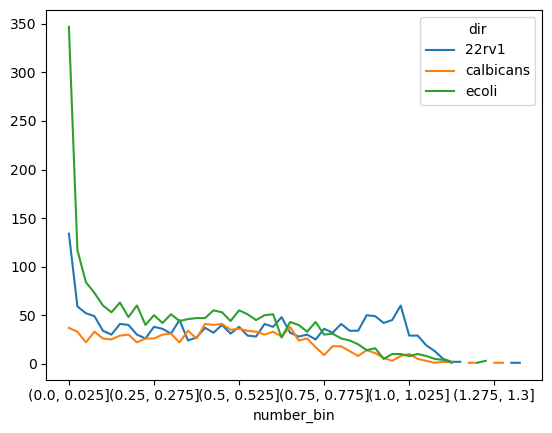

In [22]:
bins = np.arange(0,1.75,0.025)
df_tmp = df_rsa_all

df_tmp['number_bin'] = pd.cut(df_tmp['relativeTotal'], bins=bins)
df_tmp.groupby(['number_bin',"dir"], observed=True)['relativeTotal'].count().unstack(0).T.plot.line();


### Normalized histograms

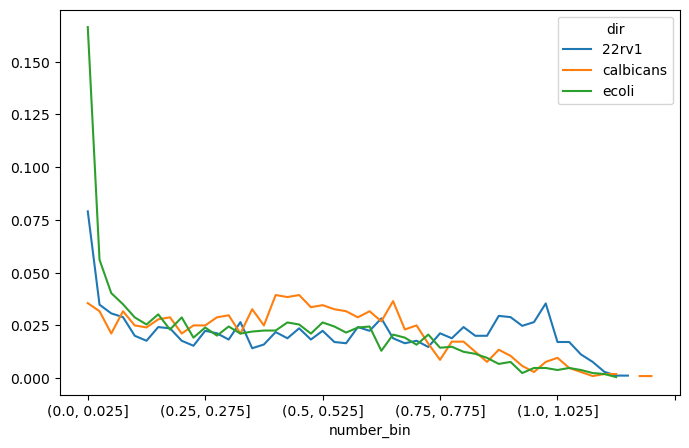

In [23]:
bins = np.arange(0,1.25,0.025)
df_tmp = df_rsa_all

df_tmp['number_bin'] = pd.cut(df_tmp['relativeTotal'], bins=bins)
hists = df_tmp.groupby(['number_bin','dir'], observed=True)['relativeTotal'].count().unstack(0)
sums = hists.sum(axis=1)
hists.div(sums, axis=0).T.plot.line(figsize=(8,5));

### Normalized histograms faceted by species

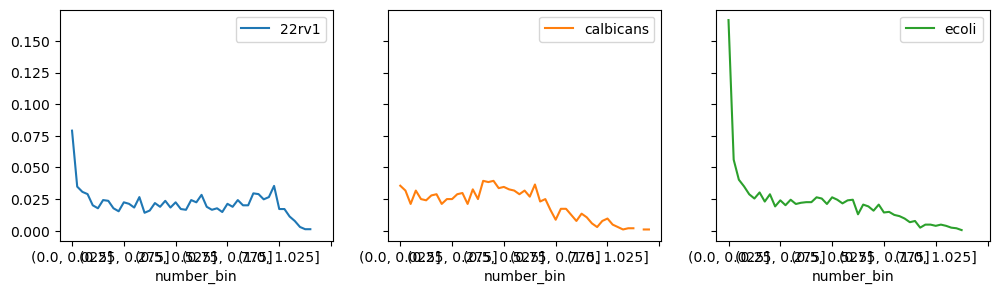

In [24]:
bins = np.arange(0,1.25,0.025)
df_tmp = df_rsa_all

df_tmp['number_bin'] = pd.cut(df_tmp['relativeTotal'], bins=bins)
hists = df_tmp.groupby(['number_bin','dir'], observed=True)['relativeTotal'].count().unstack(0)
sums = hists.sum(axis=1)
hists.div(sums, axis=0).T.plot.line(figsize=(12,3), subplots=True, layout=(1,3), sharey=True);

## Creating a DataFrame with the normalized histogram data for further plotting

In [25]:
bins = np.arange(0,1.25,0.025)
df_tmp = df_rsa_all

df_tmp['number_bin'] = pd.cut(df_tmp['relativeTotal'], bins=bins)
hists = df_tmp.groupby(['number_bin','residueType','dir'], observed=True)['relativeTotal'].count().unstack(0)
sums = hists.sum(axis=1)
norm_hists = hists.div(sums, axis=0)

### Trying to "tidy" the histogram data to make plotting easier

- You need to `.reset_index()` to get the bins into the DataFrame so they'll be preserved in the `.melt()`
- They're a pain to deal with as a multi-index...
- When referencing during the melt **the name has to be a tuple with an empty string as the second entry**

### Testing / viewing the results of the transpose and reset_index

In [26]:
norm_hists.T.reset_index().head()

residueType     number_bin       ALA                           ARG            \
dir                            22rv1 calbicans     ecoli     22rv1 calbicans   
0             (0.0, 0.025]  0.072917  0.037383  0.211180  0.012346  0.071429   
1            (0.025, 0.05]  0.052083  0.028037  0.074534  0.012346       NaN   
2            (0.05, 0.075]  0.020833  0.028037  0.055901  0.012346  0.023810   
3             (0.075, 0.1]  0.020833  0.056075  0.037267  0.012346       NaN   
4             (0.1, 0.125]  0.041667  0.028037  0.031056       NaN  0.047619   

residueType                 ASN                      ...       THR       TRP  \
dir             ecoli     22rv1 calbicans     ecoli  ...     ecoli     22rv1   
0            0.083333  0.044118  0.023810  0.051282  ...  0.152381  0.222222   
1            0.045455  0.014706  0.023810  0.038462  ...  0.028571       NaN   
2            0.030303  0.029412  0.023810  0.064103  ...  0.028571       NaN   
3            0.022727  0.014706  0.023810  0.051282  ...  0.038095  0.111111   
4            0.007576  0.029412  0.047619       NaN  ...  0.019048       NaN   

residueType                           TYR                           VAL  \
dir         calbicans     ecoli     22rv1 calbicans     ecoli     22rv1   
0              0.0625  0.142857  0.074074  0.063830  0.194030  0.234694   
1              0.0625  0.095238  0.018519  0.021277  0.104478  0.061224   
2              0.0625  0.047619  0.018519  0.021277  0.044776  0.091837   
3                 NaN  0.095238  0.055556  0.042553  0.014925  0.061224   
4              0.0625  0.047619  0.018519  0.042553  0.044776  0.020408   

residueType                      
dir         calbicans     ecoli  
0            0.060976  0.352941  
1            0.024390  0.050420  
2            0.012195  0.075630  
3                 NaN  0.042017  
4                 NaN  0.025210  

[5 rows x 61 columns]

### Doing the actual transpose and melt to get the tidy version

- The `number_bin` entries are `range` objects
- FYI: this includes the start value but not the end value (half-open intervals)
- `x.left` is grabbing the start value of the range so I can use standard line plots later

In [27]:
df_hist_tidy = (norm_hists
 .T
 .reset_index()
 .melt(id_vars=[('number_bin','')])
 .rename(columns={('number_bin',''):'number_bin', 'value':'probability', 'dir':'species'})
)
df_hist_tidy['RSA'] = df_hist_tidy['number_bin'].map(lambda x: x.left)
df_hist_tidy

,number_bin,residueType,species,probability,RSA
0,"(0.0, 0.025]",ALA,22rv1,0.072917,0.000
1,"(0.025, 0.05]",ALA,22rv1,0.052083,0.025
2,"(0.05, 0.075]",ALA,22rv1,0.020833,0.050
3,"(0.075, 0.1]",ALA,22rv1,0.020833,0.075
4,"(0.1, 0.125]",ALA,22rv1,0.041667,0.100
...,...,...,...,...,...
2935,"(1.1, 1.125]",VAL,ecoli,NaN,1.100
2936,"(1.125, 1.15]",VAL,ecoli,NaN,1.125
2937,"(1.15, 1.175]",VAL,ecoli,NaN,1.150
2938,"(1.175, 1.2]",VAL,ecoli,NaN,1.175


### Seaborn faceted line plots and save to PDF

This is fast now because we're not using Seaborn to calculate the histograms

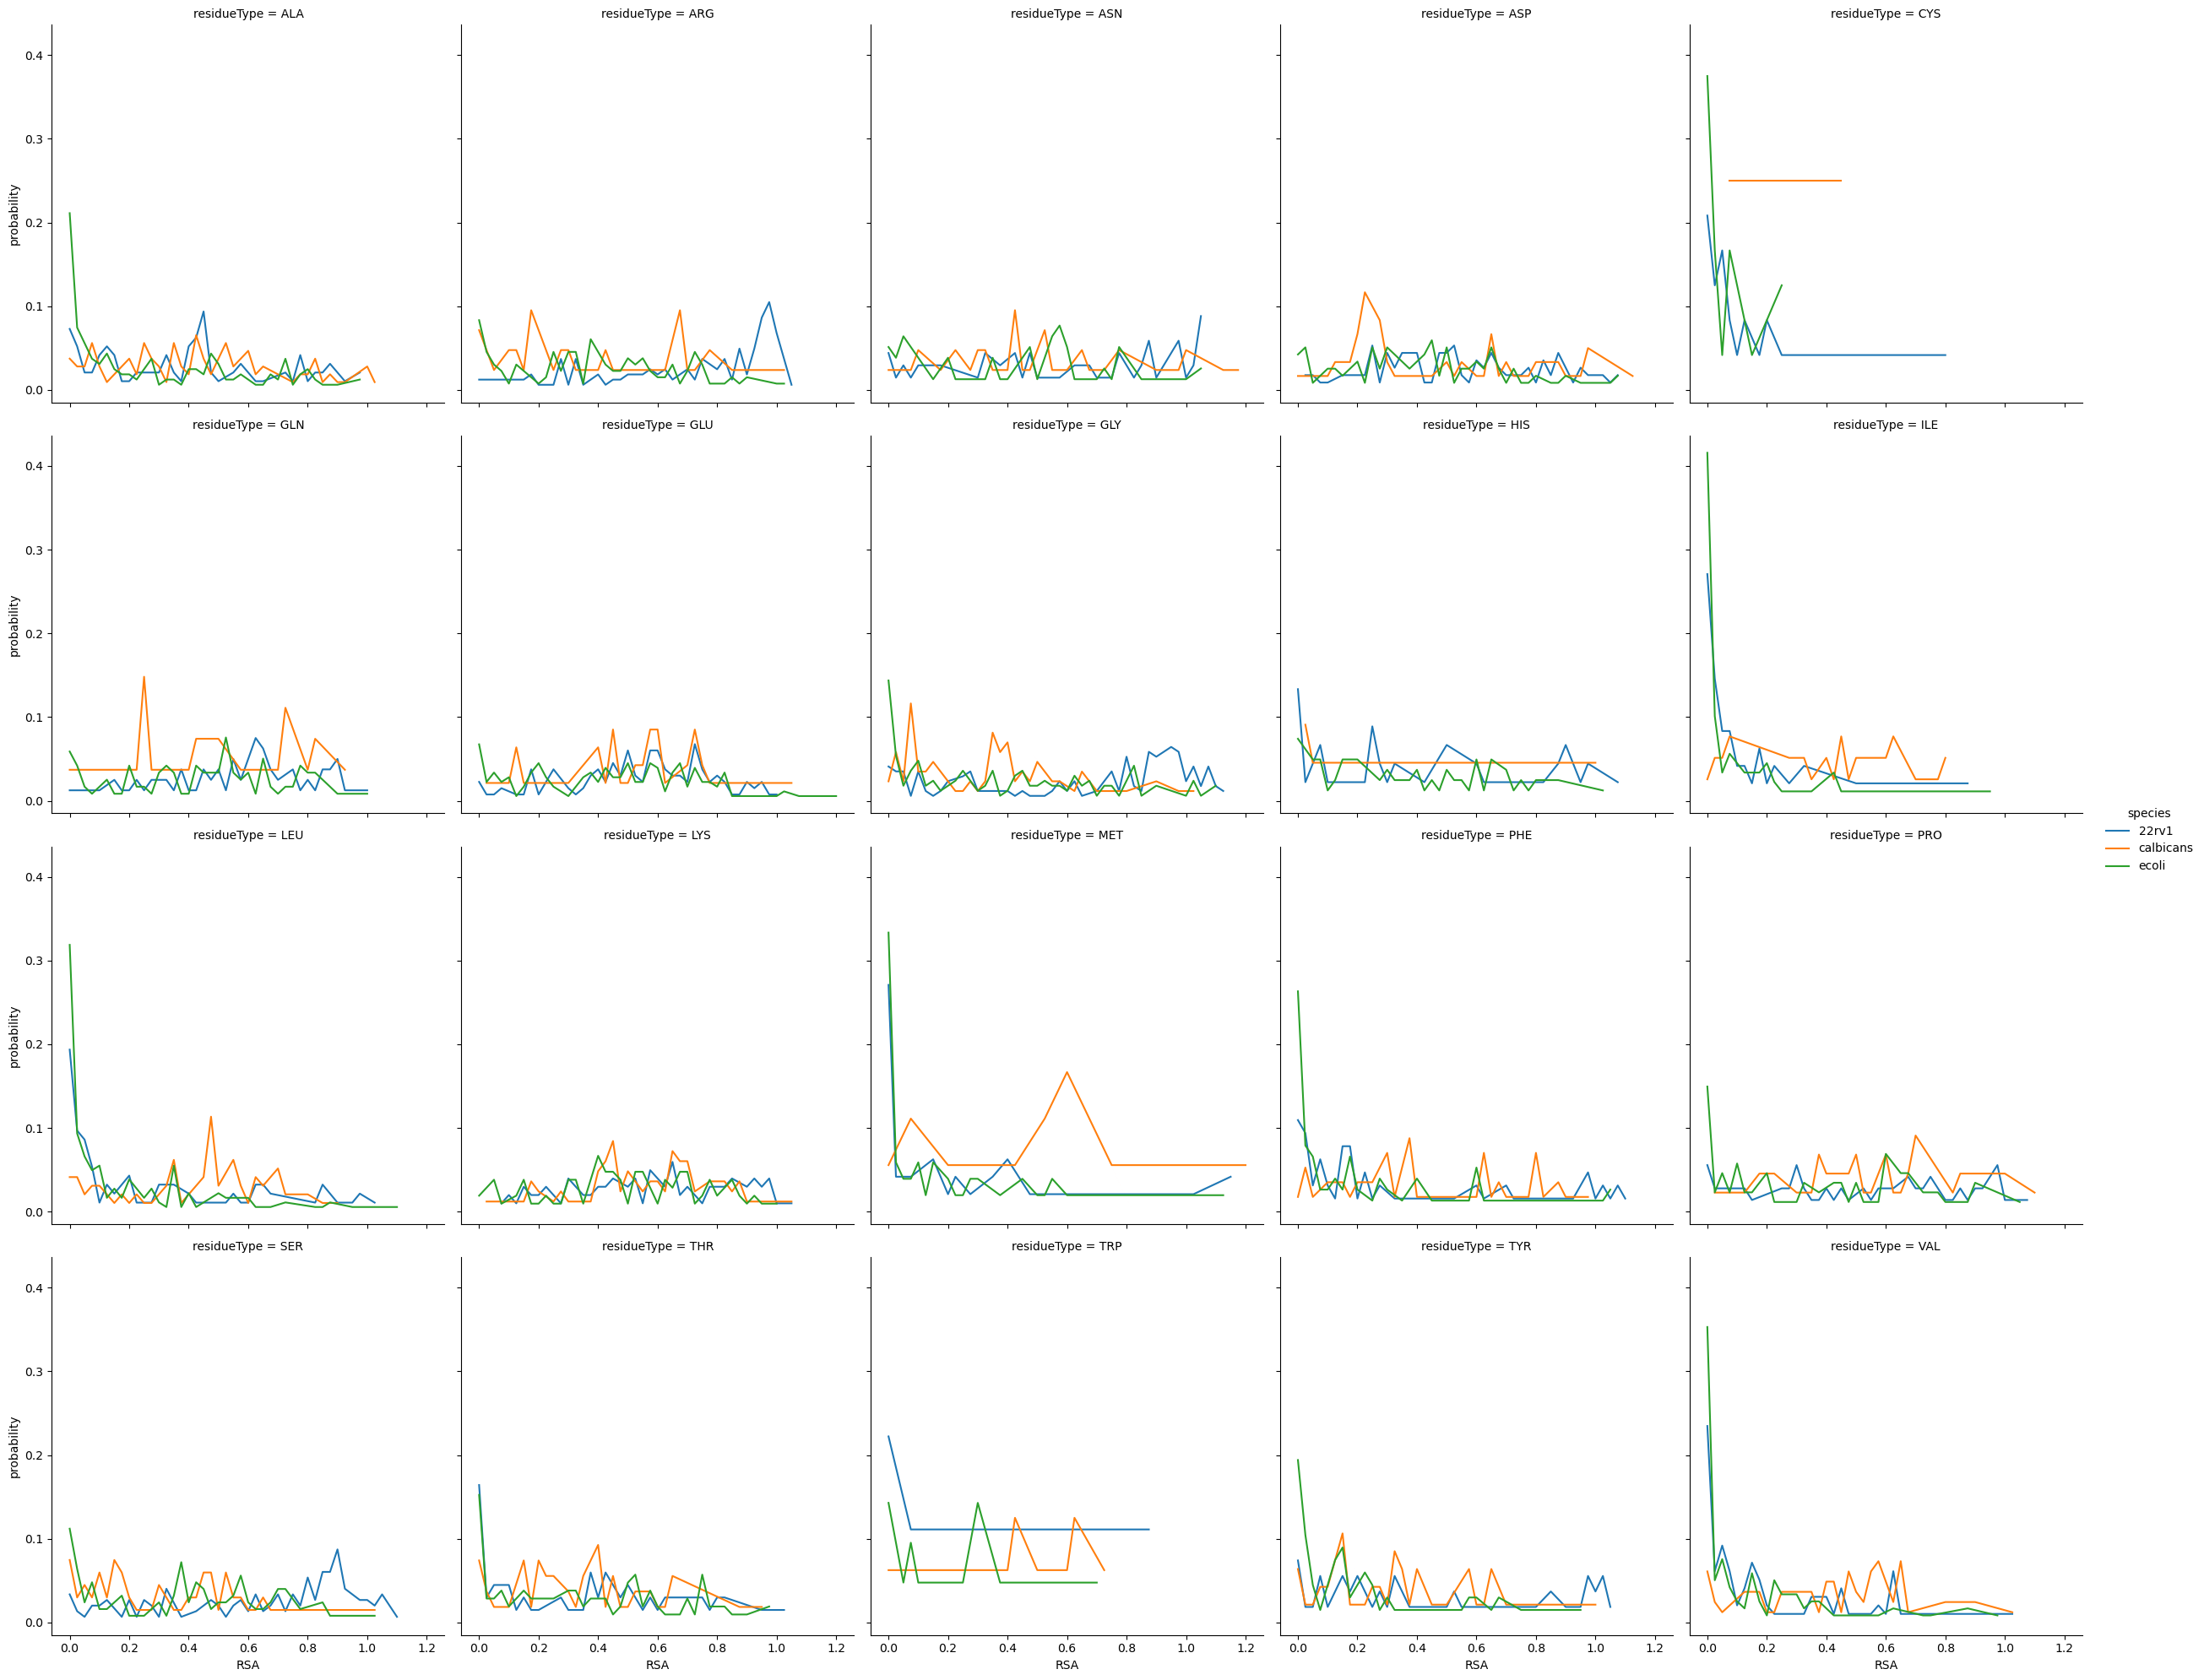

In [28]:
sns.relplot(x='RSA', y='probability', 
            hue='species',
            col='residueType', 
            data=df_hist_tidy, 
            col_wrap=5,
            kind='line').savefig(rsa_histograms_pdf)